In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from collections import defaultdict

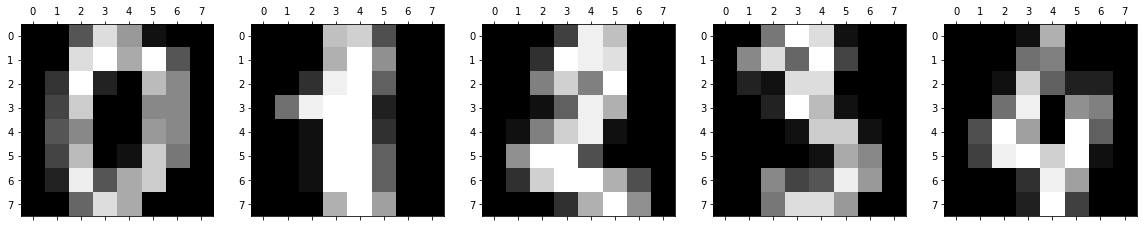

In [10]:
X, y = load_digits(return_X_y=True)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharex=True,)
plt.gray()
for i, axis in enumerate(axes):
    axis.matshow(X[i, :].reshape(8, 8))
plt.show()

In [46]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32, 16, kernel_size=2)
        self.linear = torch.nn.Linear(16, 10)

    def forward(self, x):
        relu = torch.nn.ReLU()
        maxpool = torch.nn.MaxPool2d(kernel_size=2)

        x = self.conv1(x)
        x = maxpool(relu(x))

        x = self.conv2(x)
        x = maxpool(relu(x))

        x = x.reshape(-1, 16)
        x = self.linear(x)
        return x

In [15]:
def run_one_epoch(model, optimizer, X, y, train=True):

    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    output = model(X).squeeze()
    acc = torch.sum(torch.argmax(output, dim=1) == y) / y.size(0)
    loss = torch.nn.CrossEntropyLoss()(output, y)

    if train:
        loss.backward()
        optimizer.step()

    # Detach tells torch to stop tracking a tensor's gradients
    return acc.detach(), loss.detach()

In [51]:
def numpy_to_tensor(lst):
    """
    Convert numpy array to torch tensor
    """
    if type(lst) == np.ndarray:
        return torch.tensor(lst).to(dtype=torch.float32)

    else:
        out = [torch.tensor(item).to(dtype=torch.float32) for item in lst]
        return tuple(out)

X, y = load_digits(return_X_y=True)
X = torch.tensor(X.reshape(-1, 1, 8, 8)).to(dtype=torch.float32)
y = torch.tensor(y).to(dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

torch.Size([1437, 1, 8, 8]) torch.Size([360, 1, 8, 8])


In [55]:
def demo(n_epochs=10, verbose=False):
    model = CNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    results = defaultdict(list)
    for i in range(n_epochs):
        train_acc, train_loss = run_one_epoch(model, optimizer, X_train, y_train, train=True)
        test_acc, test_loss = run_one_epoch(model, optimizer, X_test, y_test, train=False)

        results["train_acc"].append(train_acc)
        results["test_acc"].append(test_acc)
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

        if (i + 1) % (n_epochs // 10) == 0:
            train_stats = f"Train loss: {train_loss:.3f} Train accuracy: {100 * train_acc:4.1f}%"
            test_stats = f"Test loss: {test_loss:.3f} Test accuracy: {100 * test_acc:.1f}%"
            print(f"{i + 1:4d} {train_stats} {test_stats}")

    return results

In [58]:
results = demo(1000)

 100 Train loss: 0.658 Train accuracy: 84.6% Test loss: 0.659 Test accuracy: 84.2%
 200 Train loss: 0.228 Train accuracy: 94.9% Test loss: 0.279 Test accuracy: 91.9%
 300 Train loss: 0.100 Train accuracy: 98.1% Test loss: 0.183 Test accuracy: 94.4%
 400 Train loss: 0.053 Train accuracy: 99.3% Test loss: 0.164 Test accuracy: 95.3%
 500 Train loss: 0.029 Train accuracy: 99.7% Test loss: 0.167 Test accuracy: 95.6%
 600 Train loss: 0.018 Train accuracy: 100.0% Test loss: 0.174 Test accuracy: 95.8%
 700 Train loss: 0.011 Train accuracy: 100.0% Test loss: 0.181 Test accuracy: 95.6%
 800 Train loss: 0.008 Train accuracy: 100.0% Test loss: 0.189 Test accuracy: 95.6%
 900 Train loss: 0.006 Train accuracy: 100.0% Test loss: 0.196 Test accuracy: 95.6%
1000 Train loss: 0.004 Train accuracy: 100.0% Test loss: 0.203 Test accuracy: 95.8%


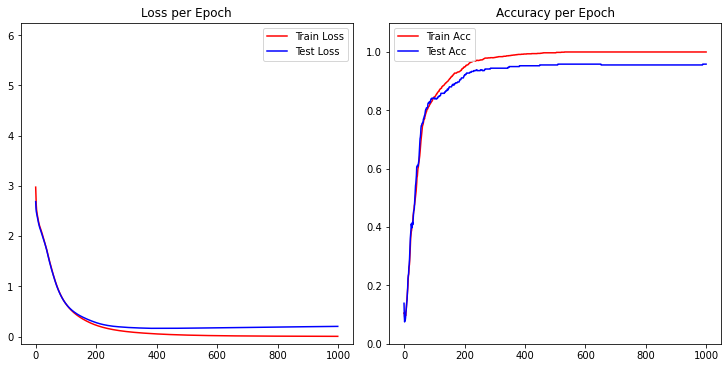

In [61]:
def plot(results):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
                             constrained_layout=True)

    ax = axes[0]
    ax.set_title("Loss per Epoch")
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    n_epochs = len(train_loss)
    ax.plot(np.arange(n_epochs), train_loss, c='r', label='Train Loss')
    ax.plot(np.arange(n_epochs), test_loss, c='b', label='Test Loss')
    ax.legend(loc="best")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, 2 * ymax)

    # Bottom right
    ax = axes[1]
    ax.set_title("Accuracy per Epoch")
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    n_epochs = len(train_acc)
    ax.plot(np.arange(n_epochs), train_acc, c='r', label='Train Acc')
    ax.plot(np.arange(n_epochs), test_acc, c='b', label='Test Acc')
    ax.legend(loc="best")
    ax.set_ylim(0, 1.1)

    plt.show()
plot(results)